Job Shop Problem inspiriert von https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/04.03-Job-Shop-Scheduling.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.8 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Schedule by Job
                               Start  Duration  Finish
Job              Machine                              
Brezel           Spiralkneter   10.0        45    55.0
                 Teigteiler     55.0        20    75.0
                 Stikkenofen    75.0        10    85.0
Mehrkörnbrötchen Spiralkneter    0.0        10    10.0
                 Teigteiler     25.0        12    37.0
                 Stikkenofen    37.0        34    71.0
Mürbteigböden    Spiralkneter   55.0        17    72.0
                 Stikkenofen    72.0        28   100.0
Rüstzeit         Stikkenofen     0.0        45    45.0
                 Teigteiler      0.0        25    25.0
                 Spiralkneter   72.0        15    87.0

Schedule by Machine
                               Start  Duration  Finish
Machine      Job                                      
Spiralkneter Mehrkörnbrötchen    0.0        10    10.0
             Brezel             10.0        45    55.0
             Mürbteigböden 

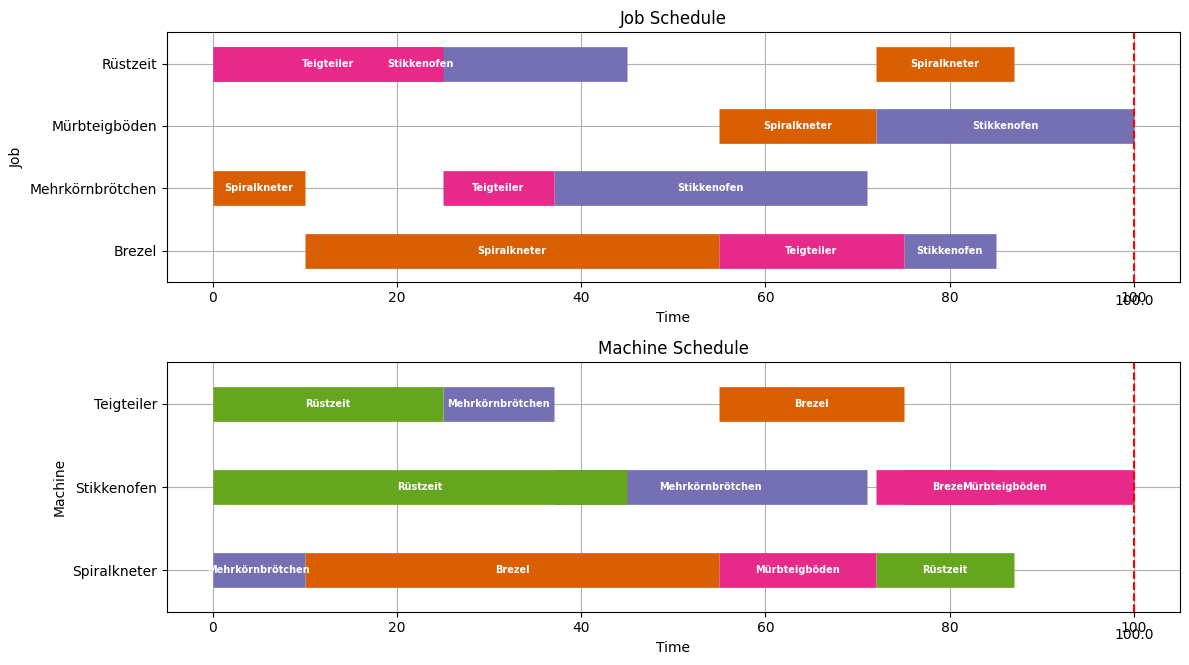

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
from pyomo.environ import *
from pyomo.gdp import *

TASKS = {
    ('Rüstzeit', 'Stikkenofen') : {'dur': 45, 'prec': None},
    ('Rüstzeit', 'Spiralkneter') : {'dur': 15, 'prec': None},
    ('Rüstzeit', 'Teigteiler') : {'dur': 25, 'prec': None},
    ('Brezel','Spiralkneter')   : {'dur': 45, 'prec': None},
    ('Brezel','Stikkenofen') : {'dur': 10, 'prec': ('Brezel','Teigteiler')},
    ('Brezel','Teigteiler')   : {'dur': 20, 'prec': ('Brezel','Spiralkneter')},
    ('Mehrkörnbrötchen','Spiralkneter')  : {'dur': 10, 'prec': None},
    ('Mehrkörnbrötchen','Stikkenofen') : {'dur': 34, 'prec': ('Mehrkörnbrötchen','Teigteiler')},
    ('Mehrkörnbrötchen','Teigteiler')   : {'dur': 12, 'prec': ('Mehrkörnbrötchen','Spiralkneter')},
    ('Mürbteigböden','Spiralkneter')  : {'dur': 17, 'prec': None},
    ('Mürbteigböden','Stikkenofen') : {'dur': 28, 'prec': ('Mürbteigböden', 'Spiralkneter')},
}

def jobshop_model(TASKS):

    model = ConcreteModel()

    # Es muss sichergestellt sein, dass Ofen der letzte Schritt ist
    # def stikkenofen_last(model, j):
    #  stikken_start = model.start[j, 'Stikkenofen']
    #  return sum(model.start[j, m] + model.dur[j, m] for m in model.MACHINES if (j, m) in model.TASKS and m != 'Stikkenofen') <= stikken_start

    # model.StikkenofenLast = Constraint(model.JOBS, rule=stikkenofen_last)


    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)

    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))

    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))

    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])

    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    # Ofen können gleichzeitig laufen -> alle produkte
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
    filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS and not (m == 'Stikkenofen' and not j.startswith('R_') and not k.startswith('R_')))

    # ofen nicht gleichzeitig,..
    # model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
    # filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS and not (m == 'Stikkenofen'))


    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j, m] for (j,m) in model.TASKS])

    # create decision variables
    model.makespan = Var(bounds=(0, ub))
    model.start = Var(model.TASKS, bounds=(0, ub))

    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:
        model.start[j,m] + model.dur[j,m] <= model.makespan)

    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n:
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])

    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] <= model.start[k,m],
         model.start[k,m] + model.dur[k,m] <= model.start[j,m]])

    TransformationFactory('gdp.hull').apply_to(model)

    return model

jobshop_model(TASKS)

def jobshop_solve(model):
    SolverFactory('cbc').solve(model)
    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](),
                'Duration': model.dur[j,m],
                'Finish': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS):
    return jobshop_solve(jobshop_model(TASKS))

results = jobshop(TASKS)
results

schedule = pd.DataFrame(results)

print('\nSchedule by Job')
print(schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine']))

print('\nSchedule by Machine')
print(schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job']))

def visualize(results):

    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()

    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center', 'fontsize': '7'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)

    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')

    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)

    fig.tight_layout()

visualize(results)


